In [194]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from pandas import DataFrame, Series
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error



In [195]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [196]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]

In [197]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.456,0.428,0.401,0.436
1,8480039,Martin Necas,Necas,C,CAR,82,R,0.610,0.621,0.601,0.597
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,78,L,0.434,0.441,0.438,0.435
3,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,0.463,0.442,0.425,0.466
4,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,0.509,0.503,0.487,0.490
...,...,...,...,...,...,...,...,...,...,...,...
467,8478831,Kevin Stenlund,Stenlund,C,FLA,86,R,0.495,0.511,0.488,0.482
468,8476483,Rickard Rakell,Rakell,R,PIT,70,R,0.522,0.523,0.525,0.516
469,8474715,Cam Atkinson,Atkinson,R,PHI,70,R,0.489,0.467,0.498,0.518
470,8477573,Nathan Walker,Walker,L,STL,45,L,0.433,0.417,0.427,0.430


In [198]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [199]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'goals', 'penaltyMinutes', 'plusMinus', 'points', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'gameWinningGoals','otGoals', 'shGoals']]

In [200]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,82,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,1,0,0
2,8475763,Kevin Hayes,Hayes,R,STL,79,2,0,0
3,8471698,T.J. Oshie,Oshie,R,WSH,56,4,0,0
4,8482259,Bobby McMann,McMann,C,TOR,56,0,0,0
...,...,...,...,...,...,...,...,...,...
467,8481553,Bobby Brink,Brink,R,PHI,57,2,0,0
468,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,3,1,1
469,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,0,0,1
470,8478400,Colin White,White,C,"PIT,MTL",28,0,0,0


In [201]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId')
df_players_merged.drop(['skaterFullName_y', 'lastName_y', 'positionCode_y', 'teamAbbrevs_y', 'gamesPlayed_y'], axis=1, inplace=True)
df_players_merged.columns = ['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']
df_players_merged = df_players_merged[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']]

In [202]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose']

for stat in percentages:
    df_players_merged[stat] *= 100

df_players_merged['teamAbbrevs'] = df_players_merged['teamAbbrevs'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

In [203]:
def headshot(row):
    headshot_link = 'https://assets.nhle.com/mugs/nhl/20232024/' + str(row['teamAbbrevs']) + '/' + str(row['playerId']) + '.png'
    return headshot_link

df_players_merged['headshot'] = df_players_merged.apply(headshot, axis=1)

In [204]:
def logo(row):
    logo_link = 'https://assets.nhle.com/logos/nhl/svg/' + str(row['teamAbbrevs']) + '_dark.svg'
    return logo_link

df_players_merged['logo'] = df_players_merged.apply(logo, axis=1)

In [205]:
columns = ['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals']

def percentile(row, column):
    percentile_score = stats.percentileofscore(df_players_merged[column], row[column])
    return percentile_score

for column in columns:
    df_players_merged[column + 'Percentile'] = df_players_merged.apply(lambda row: percentile(row, column), axis = 1)
    df_players_merged[column + 'Percentile'] = df_players_merged[column + 'Percentile'].round(2)

df_players_merged['tiedPercentile'] =  ((df_players_merged['satPercentageTiedPercentile'] + df_players_merged['usatPercentageTiedPercentile']) / 2).round(2)
df_players_merged['closePercentile'] = ((df_players_merged['usatPercentageClosePercentile'] + df_players_merged['satPercentageClosePercentile']) / 2).round(2)
df_players_merged['final'] = (0.3 * df_players_merged['tiedPercentile'] + 0.3 * df_players_merged['closePercentile'] + 0.4 * df_players_merged['gameWinningGoalsPercentile']).round(2)
df_players_merged['finalRank'] = df_players_merged['final'].rank(ascending=False)


In [206]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,logo,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,45.6,42.8,40.1,...,https://assets.nhle.com/logos/nhl/svg/COL_dark...,23.31,11.12,4.03,13.45,37.18,7.57,18.38,22.66,401.0
1,8480039,Martin Necas,Necas,C,CAR,82,R,61.0,62.1,60.1,...,https://assets.nhle.com/logos/nhl/svg/CAR_dark...,99.15,99.89,98.83,98.31,71.08,99.36,98.73,87.86,29.0
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,78,L,43.4,44.1,43.8,...,https://assets.nhle.com/logos/nhl/svg/NYI_dark...,11.97,17.37,16.63,13.03,71.08,17.00,12.50,37.28,327.0
3,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,46.3,44.2,42.5,...,https://assets.nhle.com/logos/nhl/svg/MTL_dark...,26.48,17.58,12.61,29.24,13.45,15.10,27.86,18.27,420.0
4,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,50.9,50.3,48.7,...,https://assets.nhle.com/logos/nhl/svg/STL_dark...,60.38,55.72,42.80,45.97,88.67,49.26,53.18,66.20,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,8478831,Kevin Stenlund,Stenlund,C,FLA,86,R,49.5,51.1,48.8,...,https://assets.nhle.com/logos/nhl/svg/FLA_dark...,47.88,60.38,43.54,38.24,71.08,51.96,43.06,56.94,194.0
468,8476483,Rickard Rakell,Rakell,R,PIT,70,R,52.2,52.3,52.5,...,https://assets.nhle.com/logos/nhl/svg/PIT_dark...,72.56,71.50,70.23,65.78,56.04,70.87,69.17,64.43,138.0
469,8474715,Cam Atkinson,Atkinson,R,PHI,70,R,48.9,46.7,49.8,...,https://assets.nhle.com/logos/nhl/svg/PHI_dark...,44.81,31.25,52.01,67.27,71.08,41.63,56.04,57.73,189.0
470,8477573,Nathan Walker,Walker,L,STL,45,L,43.3,41.7,42.7,...,https://assets.nhle.com/logos/nhl/svg/STL_dark...,11.44,7.94,12.92,11.02,13.45,10.43,11.23,11.88,450.0


In [207]:
df_players_merged[['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose']].describe(percentiles=[0.75, 0.8, 0.9])

,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose
count,472.000000,472.000000,472.000000,472.000000
mean,49.326907,49.368856,49.436441,49.347458
std,4.824796,5.287186,5.432530,4.911687
min,35.700000,34.100000,34.700000,34.400000
50%,49.750000,49.700000,49.600000,49.700000
75%,52.500000,52.900000,53.400000,52.700000
80%,53.080000,53.680000,54.380000,53.380000
90%,55.300000,56.190000,56.290000,55.090000
max,62.300000,62.100000,63.200000,61.600000


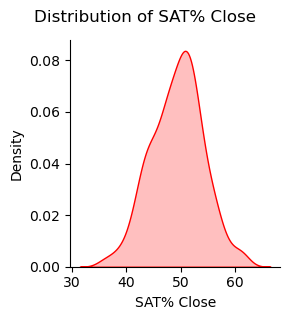

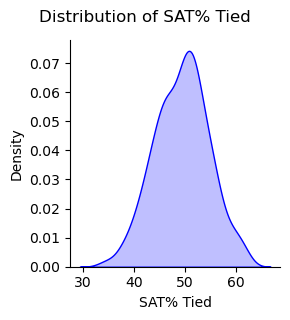

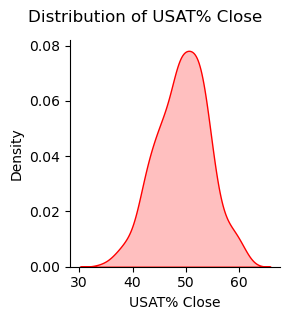

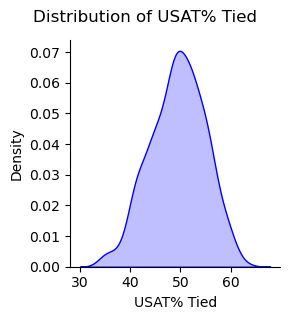

In [208]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageClose', fill=True, color='red')
satClose.fig.suptitle("Distribution of SAT% Close", y = 1.05)
satClose.set_xlabels("SAT% Close")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageTied', fill=True, color='blue')
satTied.fig.suptitle("Distribution of SAT% Tied", y = 1.05)
satTied.set_xlabels("SAT% Tied")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageClose', fill=True, color='red')
usatClose.fig.suptitle("Distribution of USAT% Close", y = 1.05)
usatClose.set_xlabels("USAT% Close")

usatTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageTied', fill=True, color='blue')
usatTied.fig.suptitle("Distribution of USAT% Tied", y = 1.05)
usatTied.set_xlabels("USAT% Tied")

In [209]:
df_players_merged[['gameWinningGoals', 'otGoals', 'shGoals']].describe(percentiles=[0.75, 0.8, 0.9])

,gameWinningGoals,otGoals,shGoals
count,472.000000,472.000000,472.000000
mean,2.233051,0.319915,0.449153
std,2.336984,0.678284,0.848102
min,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000
80%,4.000000,1.000000,1.000000
90%,5.000000,1.000000,2.000000
max,12.000000,3.000000,6.000000


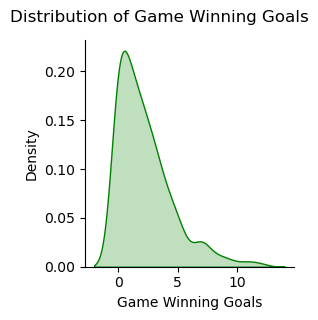

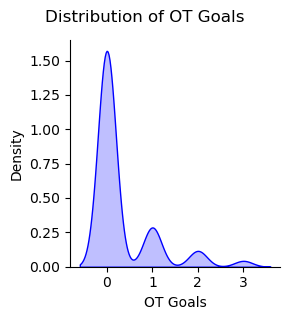

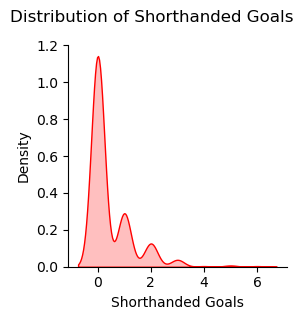

In [210]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'gameWinningGoals', fill=True, color='green')
satClose.fig.suptitle("Distribution of Game Winning Goals", y = 1.05)
satClose.set_xlabels("Game Winning Goals")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'otGoals', fill=True, color='blue')
satTied.fig.suptitle("Distribution of OT Goals", y = 1.05)
satTied.set_xlabels("OT Goals")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'shGoals', fill=True, color='red')
usatClose.fig.suptitle("Distribution of Shorthanded Goals", y = 1.05)
usatClose.set_xlabels("Shorthanded Goals")

In [211]:
satCloseQuantile = df_players_merged['satPercentageClose'].quantile(0.9)
satTiedQuantile = df_players_merged['satPercentageTied'].quantile(0.9)
usatCloseQuantile = df_players_merged['usatPercentageClose'].quantile(0.9)
usatTiedQuantile = df_players_merged['usatPercentageTied'].quantile(0.9)
gameWinningGoalsQuantile = df_players_merged['gameWinningGoals'].quantile(0.85)

def binary_clutchness(row):
    clutchness = (row['satPercentageClose'] >= satCloseQuantile) or (row['satPercentageTied'] >= satTiedQuantile) or (row['usatPercentageClose'] >= usatCloseQuantile) or (row['usatPercentageTied'] >= usatTiedQuantile) and (row['gameWinningGoals'] >= gameWinningGoalsQuantile)
    if clutchness:
        return 1
    else:
        return 0
        
df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [212]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
0    403
1     69
Name: count, dtype: int64

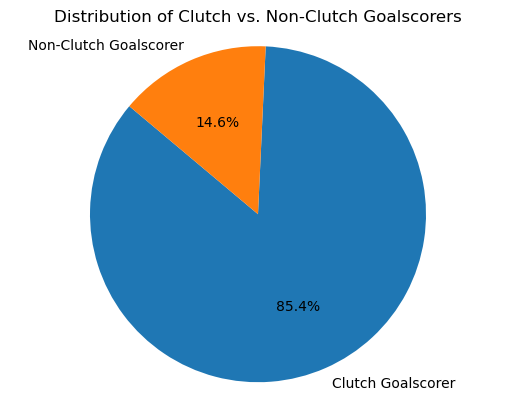

In [213]:
import matplotlib.pyplot as plt

key = ['Clutch Goalscorer', 'Non-Clutch Goalscorer']

# Create a pie chart
plt.pie(df_players_merged['clutch_performance'].value_counts(), labels=key, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Clutch vs. Non-Clutch Goalscorers')
plt.axis('equal') 
plt.show()

In [214]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.4)
model = RandomForestClassifier(n_estimators=100)
model.fit(train[x_var], train[y_var].values.ravel())

test['clutch_type'] = model.predict(test[x_var])
test['correct'] = (test['clutch_type'] == test['clutch_performance'])

test['correct'].mean()

0.9894179894179894

In [215]:
scores = cross_val_score(model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)
scores

array([1.       , 1.       , 1.       , 0.9787234, 1.       , 1.       ,
       0.9787234, 1.       , 1.       , 1.       ])

In [216]:
scores.mean()

0.9957446808510639

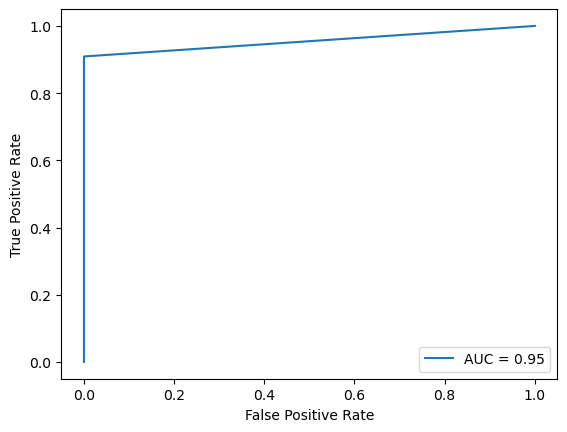

In [217]:
y_pred = model.predict(test[x_var])  
y_true = test[y_var]

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()
plt.show()

In [218]:
probs = model.predict_proba(test[x_var])[:, 1]

roc_auc = roc_auc_score(test[y_var], probs)

roc_auc

1.0

In [219]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')

In [220]:
y_pred = model.predict(test[x_var])  
y_true = test[y_var]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 1.0
Recall: 0.9090909090909091
F1 Score: 0.9523809523809523


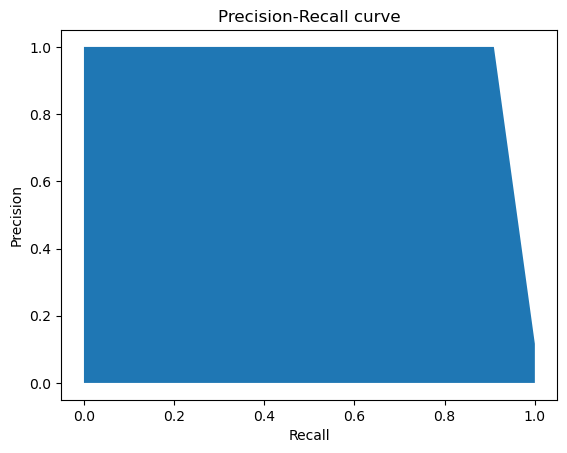

In [221]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve");

In [222]:
probs = model.predict_proba(test[x_var])[:, 1]

auc_pr = average_precision_score(test[y_var], probs)

auc_pr

1.0

In [223]:
predicted_classes = model.predict(test[x_var])
mcc = matthews_corrcoef(y_true, predicted_classes)
mcc

0.9478040075848885

Text(0.5, 0.98, 'Confusion Matrix for Predicting Clutch Goalscorers in NHL')

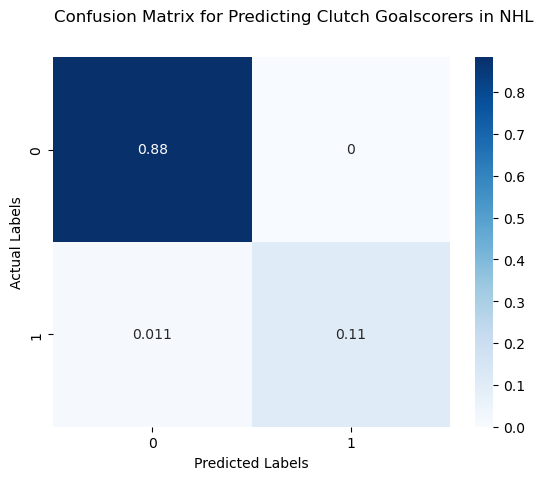

In [224]:
conf_matrix = confusion_matrix(y_true, y_pred, normalize="all")

conf_matrix

sns.heatmap(conf_matrix, cmap="Blues", annot=True)

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.suptitle('Confusion Matrix for Predicting Clutch Goalscorers in NHL')

In [225]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
accuracy

0.9894179894179894

In [226]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

train, test = train_test_split(df_players_merged, test_size=0.35)

class_weights = compute_class_weight('balanced', classes=train[y_var].unique(), y=train[y_var])

model = RandomForestClassifier(n_estimators = 100, class_weight = dict(zip(train[y_var].unique(), class_weights)))
model.fit(train[x_var], train[y_var])

accuracy = model.score(test[x_var], test[y_var])
print("Accuracy:", accuracy)


Accuracy: 0.9819277108433735


In [227]:
cv_scores = cross_val_score(model, df_players_merged[x_var], df_players_merged[y_var], cv=10)

cv_scores

array([1.        , 0.97916667, 1.        , 0.93617021, 0.9787234 ,
       0.9787234 , 0.9787234 , 0.9787234 , 1.        , 0.9787234 ])

In [228]:
cv_scores.mean()

0.980895390070922

In [229]:
dict(zip(train[y_var].unique(), class_weights))

{1: 3.25531914893617, 0: 0.5907335907335908}

In [230]:
mse = mean_squared_error(y_true, y_pred)

mse

0.010582010582010581

In [231]:
df_players_merged['gameWinningGoalsPercentile'] = df_players_merged['gameWinningGoalsPercentile'].astype(str) + '%'
df_players_merged['tiedPercentile'] = df_players_merged['tiedPercentile'].astype(str) + '%'
df_players_merged['closePercentile'] = df_players_merged['closePercentile'].astype(str) + '%'
df_players_merged['final'] = df_players_merged['final'].astype(str) + '%'

df_players_merged['finalRank'] = df_players_merged['finalRank'].astype(str).apply(lambda x: 'T-' + x.split('.5')[0] if '.5' in x else x)

In [232]:
df_players_merged.to_csv(r'C:\Users\shakj\Desktop\nhl_clutch_player_data.csv', index=False)

In [233]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank,clutch_performance
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,45.6,42.8,40.1,...,23.31,11.12,4.03,13.45,37.18%,7.57%,18.38%,22.66%,401.0,0
1,8480039,Martin Necas,Necas,C,CAR,82,R,61.0,62.1,60.1,...,99.15,99.89,98.83,98.31,71.08%,99.36%,98.73%,87.86%,29.0,1
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,78,L,43.4,44.1,43.8,...,11.97,17.37,16.63,13.03,71.08%,17.0%,12.5%,37.28%,327.0,0
3,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,46.3,44.2,42.5,...,26.48,17.58,12.61,29.24,13.45%,15.1%,27.86%,18.27%,420.0,0
4,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,50.9,50.3,48.7,...,60.38,55.72,42.80,45.97,88.67%,49.26%,53.18%,66.2%,127.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,8478831,Kevin Stenlund,Stenlund,C,FLA,86,R,49.5,51.1,48.8,...,47.88,60.38,43.54,38.24,71.08%,51.96%,43.06%,56.94%,194.0,0
468,8476483,Rickard Rakell,Rakell,R,PIT,70,R,52.2,52.3,52.5,...,72.56,71.50,70.23,65.78,56.04%,70.87%,69.17%,64.43%,138.0,0
469,8474715,Cam Atkinson,Atkinson,R,PHI,70,R,48.9,46.7,49.8,...,44.81,31.25,52.01,67.27,71.08%,41.63%,56.04%,57.73%,189.0,0
470,8477573,Nathan Walker,Walker,L,STL,45,L,43.3,41.7,42.7,...,11.44,7.94,12.92,11.02,13.45%,10.43%,11.23%,11.88%,450.0,0
